# 💬 AI Echo: Your Smartest Conversational Partner
### 📂 Dataset

**Single Dataset Used:** chatgpt_style_reviews_dataset.xlsx

🎯 Targets / Insights:

😊 Sentiment Analysis – Classify reviews as Positive, Neutral, or Negative

⭐ Rating Prediction & Trends – Understand rating behavior and satisfaction over time

### 🧭 Workflow Steps
<h4> ⚙️ Load Dataset → 🧹 Text Cleaning & Preprocessing → 🌍 Language Translation → <br> 🔠 Text Normalization & Lemmatization → 📊 Exploratory Data Analysis (EDA) → <br> 🧩 Keyword Extraction → 🔗 TF-IDF Vectorization → ✂️ Train–Test Split → <br> 🤖 Model Training & Evaluation → 🎛️ Hyperparameter Tuning → <br> 🏆 Model Selection & Saving → 📈 Insight Visualization & Summary </h4>

# 🧩  Imports & Setup

In [1]:
# AI Echo: Your Smartest Conversational Partner

# ==========================================================
# 1️⃣ Imports & Configuration
# ==========================================================
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from googletrans import Translator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
from packaging import version
from collections import Counter
import warnings
import joblib
# Ignore warnings
warnings.filterwarnings('ignore')

# 📊  Load Dataset & Target Mapping

In [2]:

# ==========================================================
# 1️⃣ Load dataset
# ==========================================================
df = pd.read_excel("chatgpt_style_reviews_dataset.xlsx")
print("✅ Dataset loaded successfully")
print("Total rows:", df.shape[0])
print("Language distribution:\n", df['language'].value_counts())

# ==========================================================
# 2️⃣ Target Creation – Map Rating → Sentiment
# ==========================================================
def map_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['sentiment'] = df['rating'].apply(map_sentiment)
print("\n🎯 Sentiment distribution:\n", df['sentiment'].value_counts())

✅ Dataset loaded successfully
Total rows: 250
Language distribution:
 language
ru    27
ar    26
es    26
zh    26
en    26
pt    24
hi    24
ja    24
fr    24
de    23
Name: count, dtype: int64

🎯 Sentiment distribution:
 sentiment
Negative    97
Positive    96
Neutral     57
Name: count, dtype: int64


# 🌍  Language Translation

In [3]:
# ==========================================================
# 3️⃣ Language Translation (Non-English → English)
# ==========================================================
translator = Translator()

def translate_to_en(text, src_lang):
    try:
        if src_lang != 'en':
            return translator.translate(text, src='auto', dest='en').text
        else:
            return text
    except Exception:
        return text

print("\n🔄 Translating non-English reviews to English...")
df['review'] = df.apply(lambda x: translate_to_en(str(x['review']), x['language']), axis=1)
df['language'] = 'en'
print("✅ All reviews translated to English.")



🔄 Translating non-English reviews to English...
✅ All reviews translated to English.


# 🧹  Text Cleaning & Lemmatization

In [4]:
# ==========================================================
# 4️⃣ Text Preprocessing
# ==========================================================
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = nltk.tokenize.RegexpTokenizer(r'\b\w+\b')

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)

    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]

    lemmatized = []
    for token, tag in nltk.pos_tag(tokens):
        pos = tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
            pos = 'n'
        lemmatized.append(lemmatizer.lemmatize(token, pos))

    return ' '.join(lemmatized)

print("\n🧹 Cleaning and lemmatizing reviews...")
df['review_clean'] = df['review'].apply(preprocess_text)
print("✅ Text preprocessing complete.")
# ==========================================================
# 🔟 Save Cleaned Dataset
# ==========================================================
df.to_csv("cleaned_reviews.csv", index=False)
print("✅ Cleaned dataset saved as 'cleaned_reviews.csv'")


🧹 Cleaning and lemmatizing reviews...
✅ Text preprocessing complete.
✅ Cleaned dataset saved as 'cleaned_reviews.csv'


# 🔍  Exploratory Data Analysis (EDA)

In [5]:
# ==========================================================
# 5️⃣ EDA – Visual Insights
# ==========================================================
df = pd.read_csv("cleaned_reviews.csv")

# Convert 'date' to datetime and handle errors
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Calculate review length (to reuse later)
df['review_length'] = df['review'].astype(str).apply(lambda x: len(x.split()))


# 📊 Distribution of Review Ratings

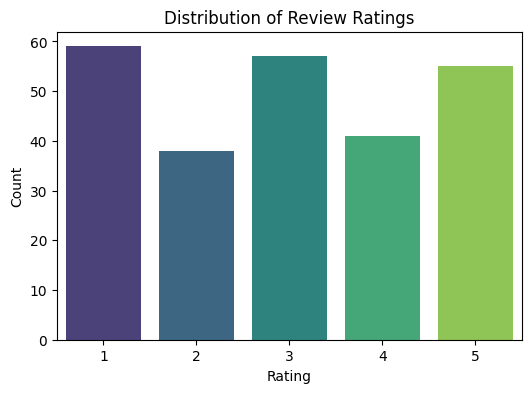

In [6]:
# ==========================================================
# 1️⃣ Distribution of Review Ratings
# ==========================================================
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# 👍👎 Helpful vs. Non-Helpful Reviews

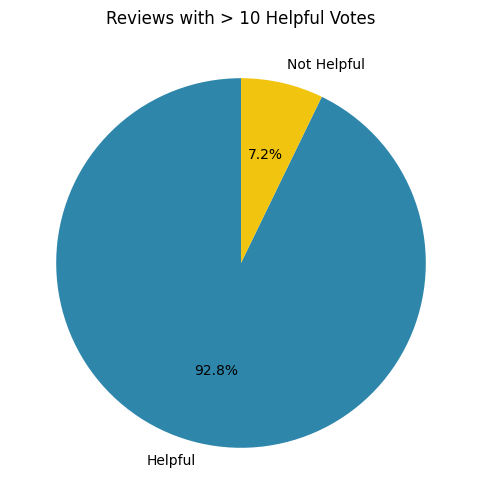

In [7]:
# ==========================================================
# 2️⃣ Reviews Marked as Helpful (Threshold > 10)
# ==========================================================
helpful_threshold = 10
helpful_counts = pd.Series({
    'Helpful': df[df['helpful_votes'] > helpful_threshold].shape[0],
    'Not Helpful': df[df['helpful_votes'] <= helpful_threshold].shape[0]
})
helpful_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['#2E86AB', '#F1C40F'],
    figsize=(6, 6),
    startangle=90,
    labels=helpful_counts.index
)
plt.title(f"Reviews with > {helpful_threshold} Helpful Votes")
plt.ylabel('')
plt.show()


# 🧭 Common Keywords in Positive and Negative Reviews

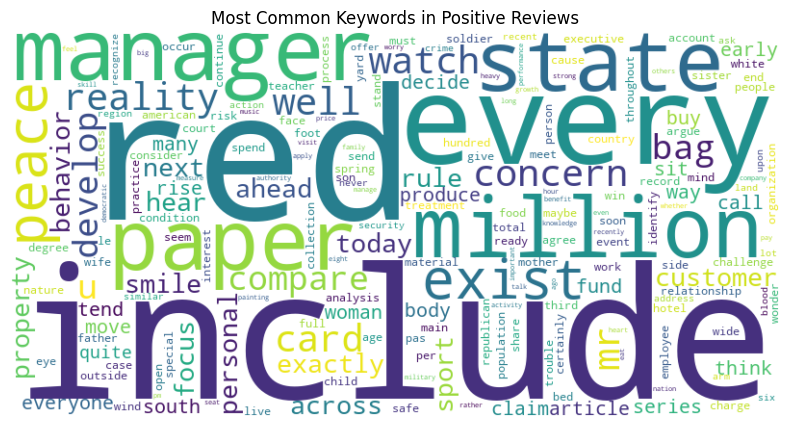

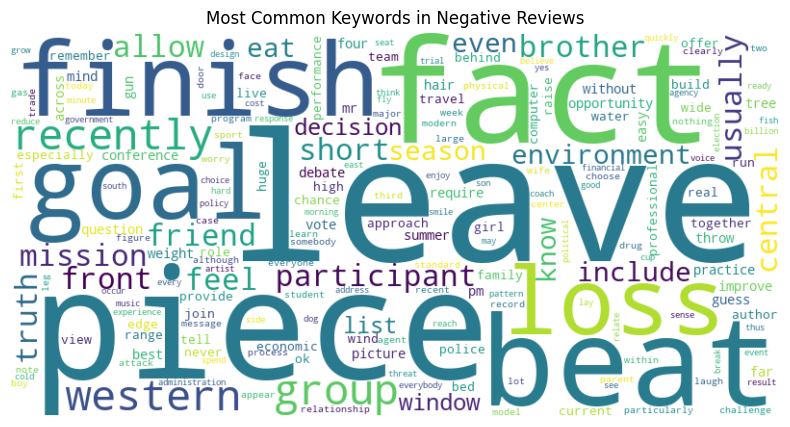

In [8]:
# ==========================================================
# 3️⃣ Most Common Keywords in Positive vs Negative Reviews
# ==========================================================
positive_text = ' '.join(df[df['rating'] >= 4]['review_clean'])
negative_text = ' '.join(df[df['rating'] <= 2]['review_clean'])

# WordClouds
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Keywords in Positive Reviews")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Keywords in Negative Reviews")
plt.show()

# 📆 Average Rating Over Time

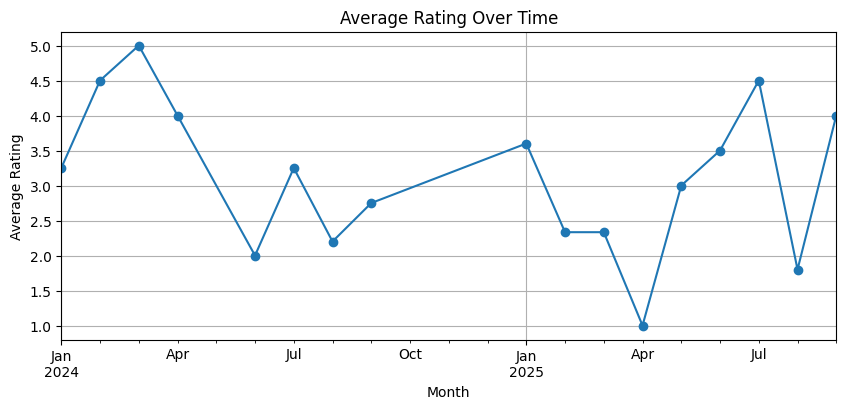

In [9]:
# ==========================================================
# 4️⃣ Average Rating Over Time
# ==========================================================
avg_rating_time = df.groupby(df['date'].dt.to_period('M'))['rating'].mean()
avg_rating_time.plot(kind='line', figsize=(10, 4), marker='o')
plt.title("Average Rating Over Time")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()

# 🌍 Ratings by User Location

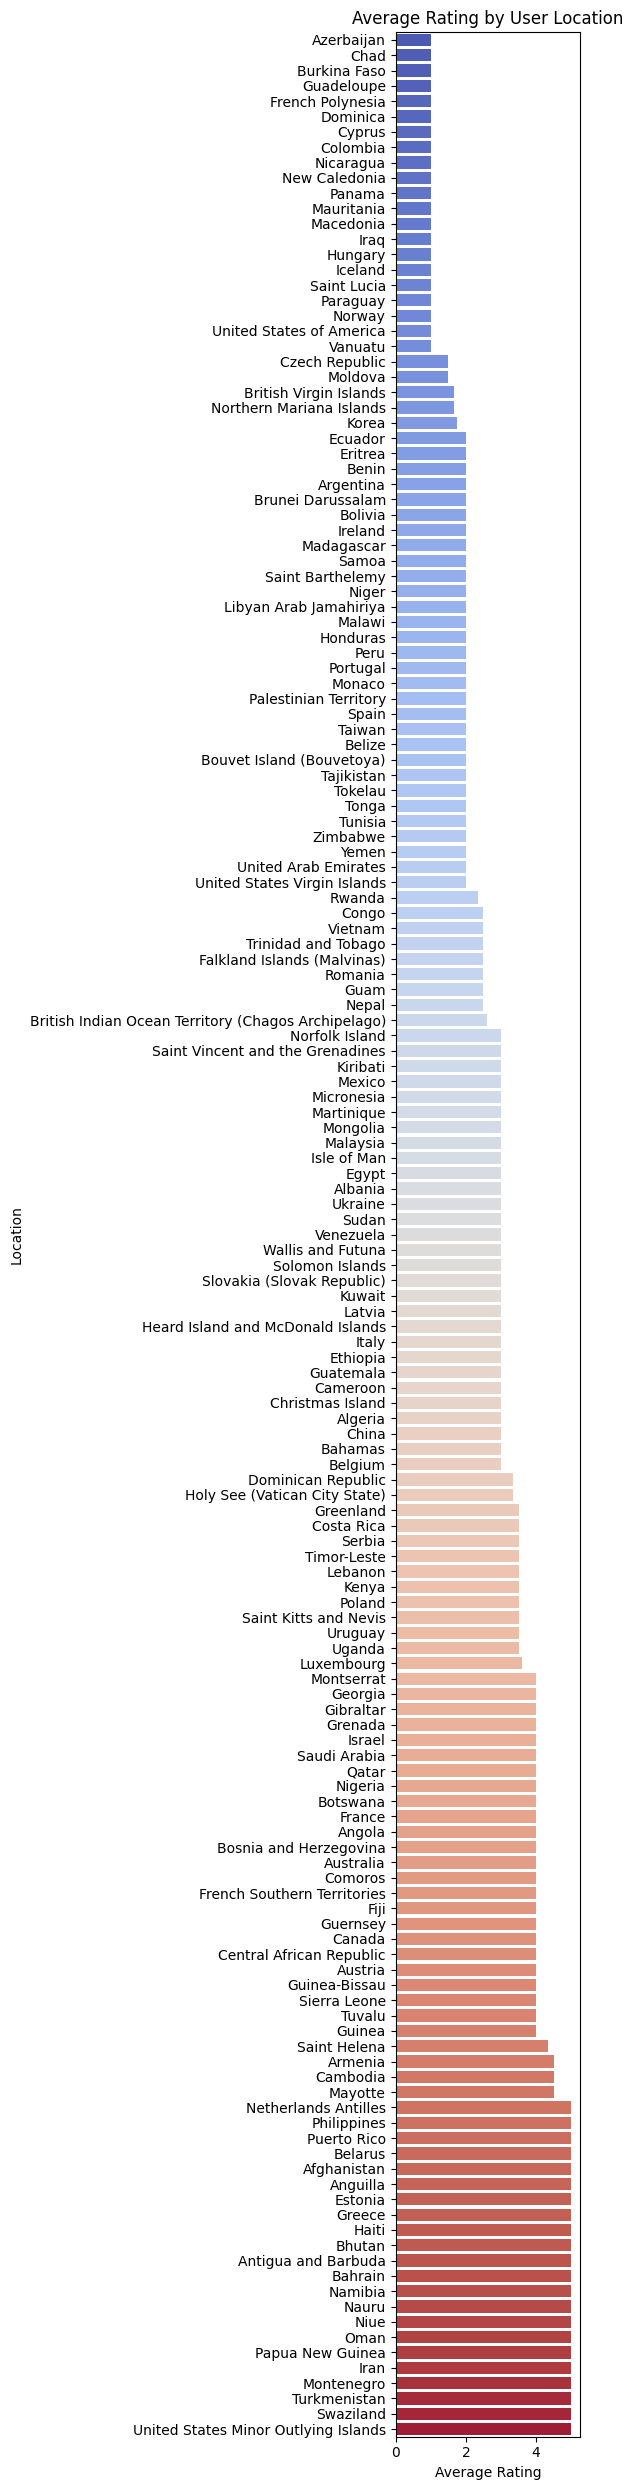

In [10]:
# ==========================================================
# 5️⃣ Ratings by User Location 
# ==========================================================
avg_rating_location = df.groupby('location')['rating'].mean().sort_values()
plt.figure(figsize=(6, 25))
sns.barplot(x=avg_rating_location.values, y=avg_rating_location.index, palette='coolwarm')
plt.title("Average Rating by User Location")
plt.xlabel("Average Rating")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

# 🧑‍💻 Platform Comparison

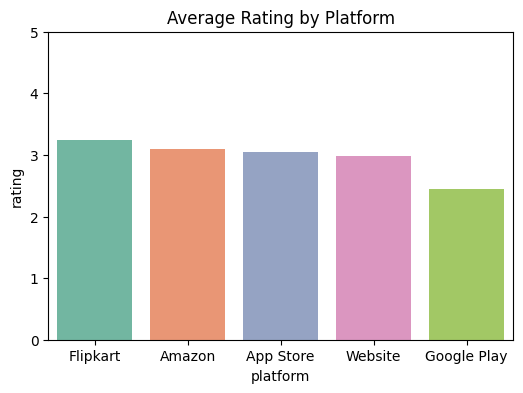

In [11]:
# ==========================================================
# 6️⃣ Platform Comparison 
# ==========================================================
plt.figure(figsize=(6, 4))
sns.barplot(x='platform', y='rating', data=df, ci=None, palette='Set2')
plt.title("Average Rating by Platform")
plt.ylim(0, 5)
plt.show()


# ✅❌ Verified vs. Non-Verified Users

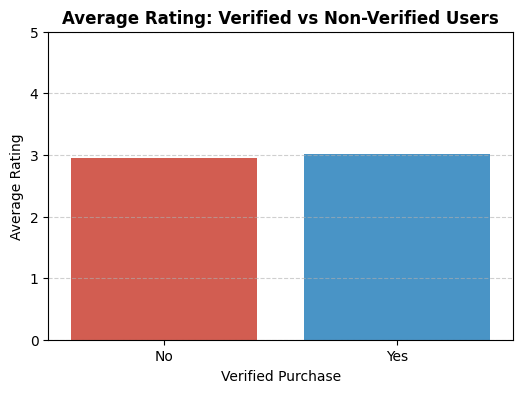

In [12]:
# ==========================================================
# 7️⃣ Verified vs Non-Verified Users
# ==========================================================
plt.figure(figsize=(6, 4))
sns.barplot(
    x='verified_purchase',
    y='rating',
    data=df,
    ci=None,
    palette=['#E74C3C', '#3498DB']
)
plt.title("Average Rating: Verified vs Non-Verified Users", fontsize=12, weight='bold')
plt.xlabel("Verified Purchase", fontsize=10)
plt.ylabel("Average Rating", fontsize=10)
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 🔠 Average Review Length by Rating

Average Review Length per Rating:
    rating  review_length
0       1      20.406780
1       2      22.394737
2       3      20.263158
3       4      20.804878
4       5      20.909091


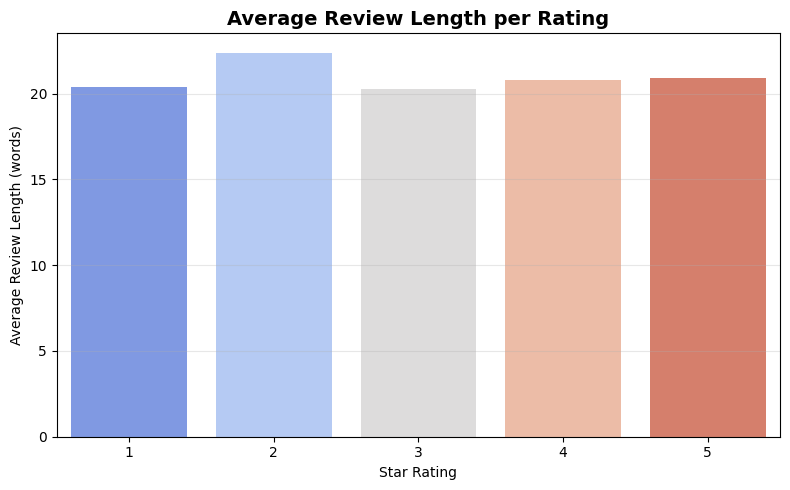

In [13]:
# ==========================================================
# 8️⃣ Review Length per Rating
# ==========================================================
avg_length = df.groupby('rating')['review_length'].mean().reset_index()
print("Average Review Length per Rating:\n", avg_length)

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_length, x='rating', y='review_length', palette='coolwarm')
plt.title("Average Review Length per Rating", fontsize=14, fontweight='bold')
plt.xlabel("Star Rating")
plt.ylabel("Average Review Length (words)")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 💬 Most Frequent Words in 1-Star Reviews

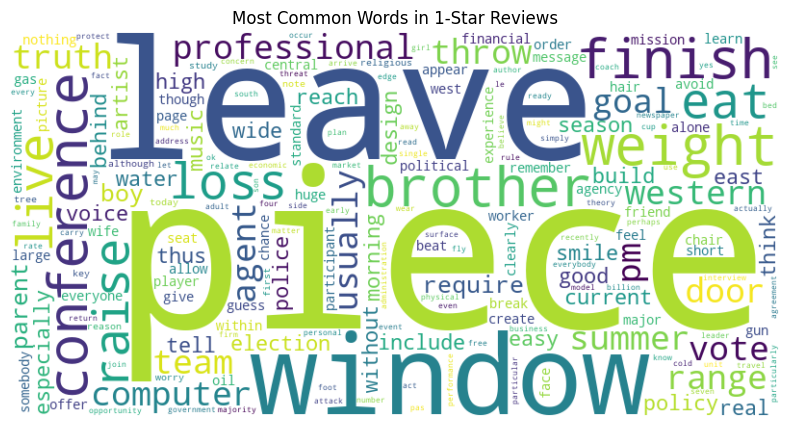

In [14]:
# ==========================================================
# 9️⃣ Most Mentioned Words in 1-Star Reviews
# ==========================================================
one_star_text = ' '.join(df[df['rating'] == 1]['review_clean'])
wordcloud_1star = WordCloud(width=800, height=400, background_color='white').generate(one_star_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1star, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in 1-Star Reviews")
plt.show()

# 📱🧪 Average Rating by ChatGPT Version

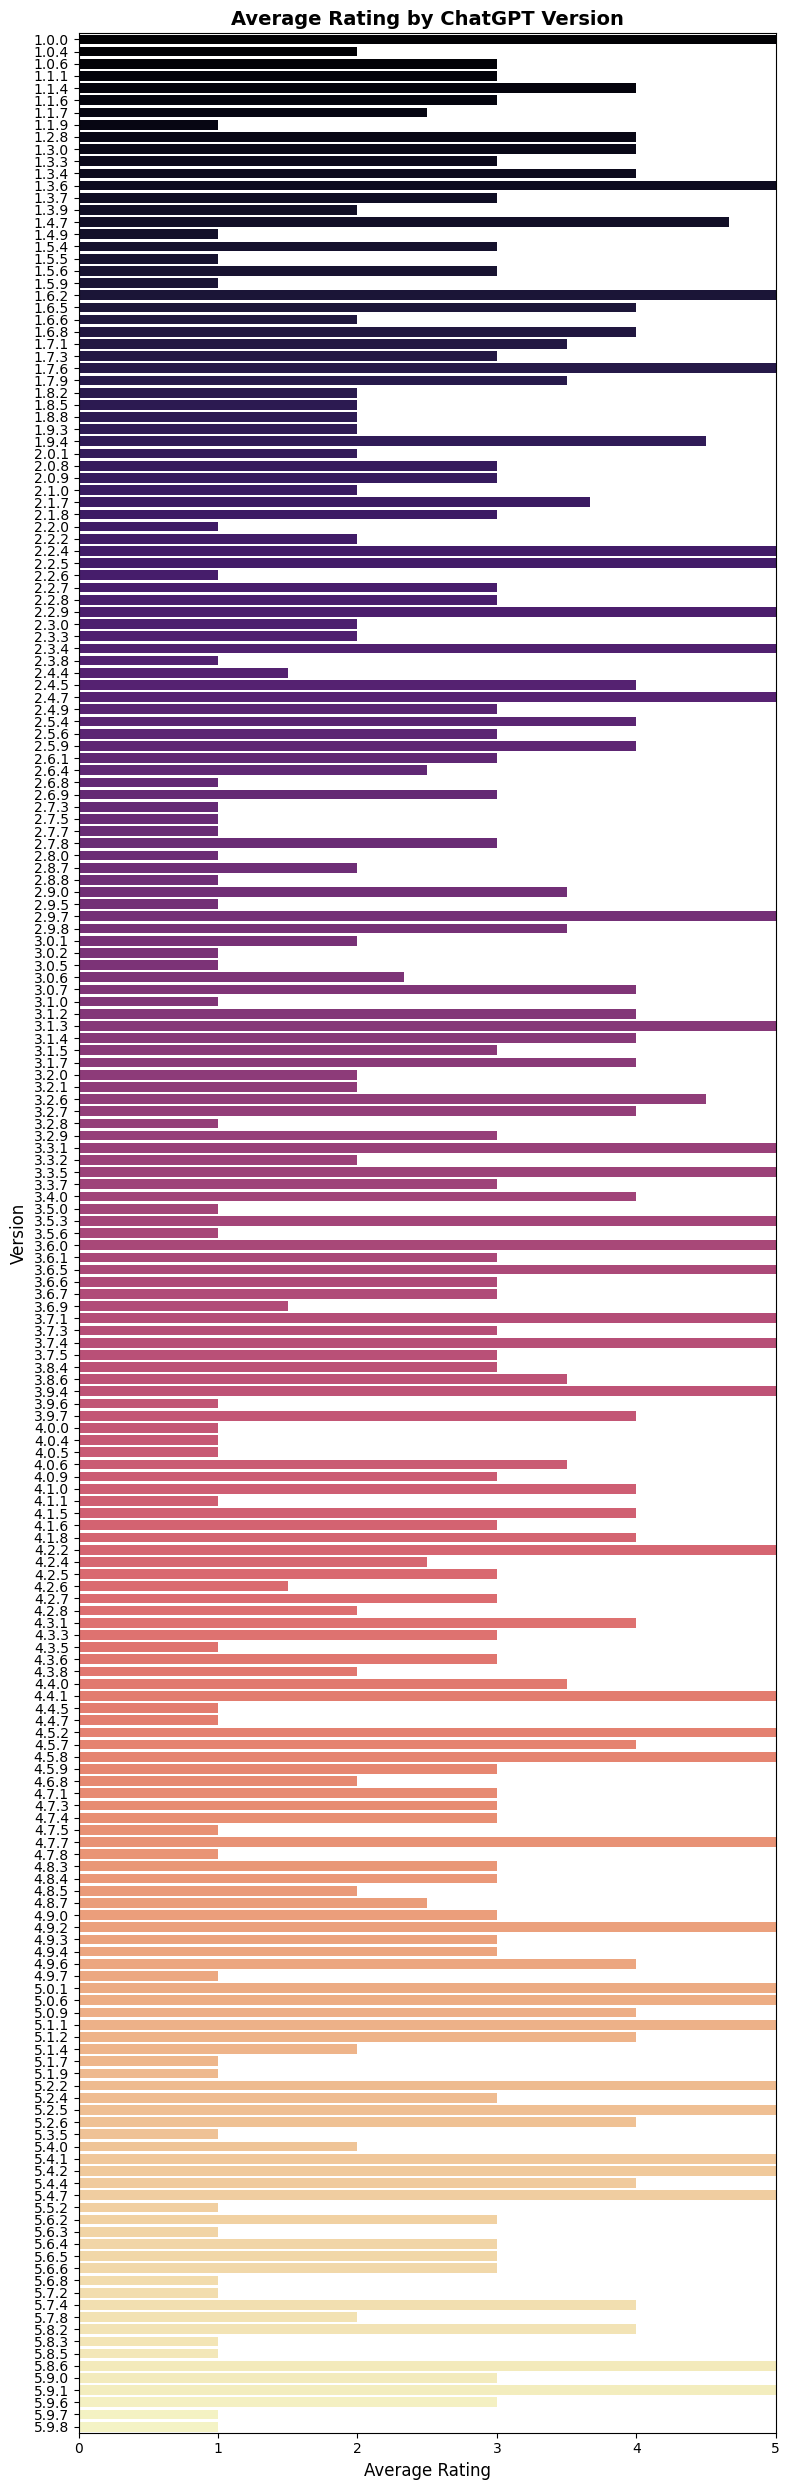

In [15]:
# ==========================================================
# 🔟 ChatGPT Version with Highest Average Rating
# ==========================================================
avg_rating_version = df.groupby('version')['rating'].mean()
version_order = sorted(avg_rating_version.index, key=version.parse)
avg_rating_version = avg_rating_version.reindex(version_order)

plt.figure(figsize=(8, 25))
sns.barplot(x=avg_rating_version.values, y=avg_rating_version.index, palette='magma')
plt.title("Average Rating by ChatGPT Version", fontsize=14, weight='bold')
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Version", fontsize=12)
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

# 🧠  TF-IDF Vectorization & Split

In [23]:
# ==========================================================
# 5️⃣ TF-IDF Vectorization
# ==========================================================
print("\n🔠 Performing TF-IDF vectorization...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['review_clean'])
print("TF-IDF matrix shape:", X_tfidf.shape)
# ✅ Save the trained vectorizer
joblib.dump(tfidf, "vectorizer.pkl")

# ==========================================================
# 6️⃣ Train-Test Split
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment']
)



🔠 Performing TF-IDF vectorization...
TF-IDF matrix shape: (250, 4649)


# 🤖  Model Training & Evaluation

In [17]:
# ==========================================================
# 7️⃣ Model Training & Evaluation
# ==========================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'),
    "Multinomial NB": MultinomialNB(),
    "SVM (LinearSVC)": LinearSVC(class_weight='balanced', max_iter=2000),
    "SVM (RBF SVC)": SVC(kernel='rbf', class_weight='balanced', gamma='scale'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, subsample=0.9, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

results = {}

print("\n🚀 Training models and evaluating...")
for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ {name} Accuracy: {acc * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    results[name] = acc


🚀 Training models and evaluating...

🔹 Training Logistic Regression...
✅ Logistic Regression Accuracy: 42.00%
              precision    recall  f1-score   support

    Negative       0.40      0.53      0.45        19
     Neutral       0.00      0.00      0.00        12
    Positive       0.46      0.58      0.51        19

    accuracy                           0.42        50
   macro avg       0.29      0.37      0.32        50
weighted avg       0.33      0.42      0.37        50


🔹 Training Multinomial NB...
✅ Multinomial NB Accuracy: 46.00%
              precision    recall  f1-score   support

    Negative       0.42      0.58      0.49        19
     Neutral       0.00      0.00      0.00        12
    Positive       0.50      0.63      0.56        19

    accuracy                           0.46        50
   macro avg       0.31      0.40      0.35        50
weighted avg       0.35      0.46      0.40        50


🔹 Training SVM (LinearSVC)...
✅ SVM (LinearSVC) Accuracy: 42.0

# 💾  Save Best Model

In [ ]:
# ==========================================================
# 💾 Save Best Model 
# ==========================================================
best_model_name = max(results, key=results.get)
best_model_acc = results[best_model_name]
print(f"\n🏆 Best Model: {best_model_name} ({best_model_acc*100:.2f}%)")

# Pickle the Gradient Boosting model
best_model = models[best_model_name]
joblib.dump(best_model, "best_model.pkl")
print("✅ Model saved as best_model.pkl")


🏆 Best Model: Gradient Boosting (54.00%)
✅ Model saved as best_model.pkl


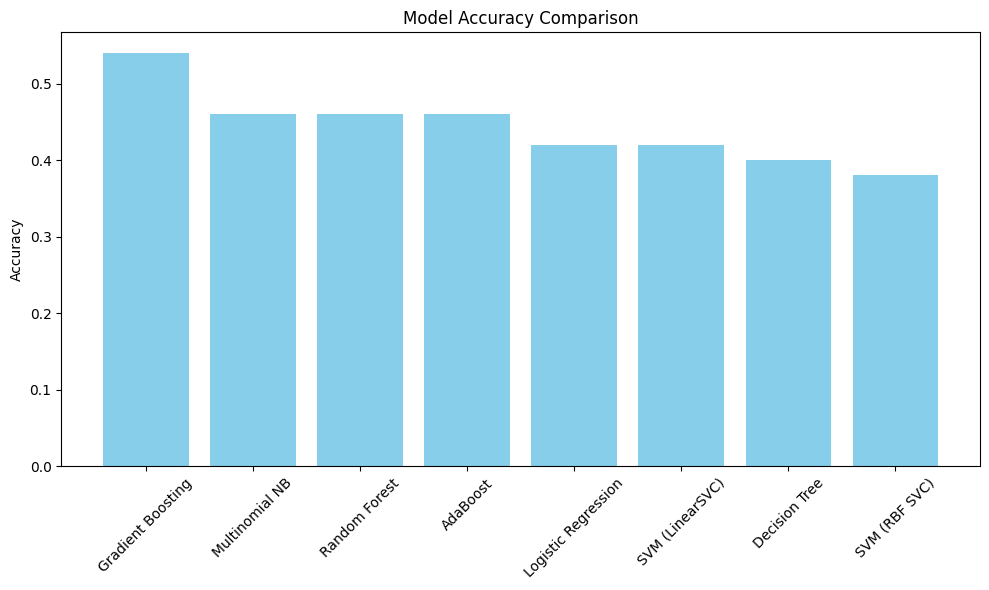

In [18]:
# ==========================================================
# 8️⃣ Model Comparison Visualization
# ==========================================================
plt.figure(figsize=(10,6))
sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
plt.bar(sorted_results.keys(), sorted_results.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()


# ⚙️  Hyperparameter Tuning

In [19]:

# ==========================================================
# 9️⃣ Hyperparameter Tuning
# ==========================================================
print("\n⚙️ Starting Hyperparameter Tuning...")

param_grids = {
    "Logistic Regression": {"C": [0.1, 0.5, 1.0, 2.0], "solver": ["liblinear", "lbfgs"]},
    "Multinomial NB": {"alpha": [0.1, 0.5, 1.0, 2.0]},
    "SVM (LinearSVC)": {"C": [0.1, 0.5, 1.0], "max_iter": [1000, 2000, 3000]},
    "SVM (RBF SVC)": {"C": [0.5, 1.0, 2.0], "gamma": ["scale", "auto"]},
    "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [None, 10, 20]},
    "Decision Tree": {"max_depth": [None, 10, 20], "criterion": ["gini", "entropy"]},
    "Gradient Boosting": {"n_estimators": [100, 150, 200], "learning_rate": [0.05, 0.1, 0.2],"subsample":[0.9,0.10,0.11]},
    "AdaBoost": {"n_estimators": [100, 150, 200], "learning_rate": [0.5, 0.8, 1.0]}
}

base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Multinomial NB": MultinomialNB(),
    "SVM (LinearSVC)": LinearSVC(class_weight='balanced'),
    "SVM (RBF SVC)": SVC(kernel='rbf', class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced_subsample', random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

tuned_results = {}

for name, model in base_models.items():
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    
    print(f"✅ Best Params for {name}: {grid.best_params_}")
    print(f"📊 Tuned Accuracy: {acc * 100:.2f}%")
    tuned_results[name] = {"best_params": grid.best_params_, "accuracy": acc}




⚙️ Starting Hyperparameter Tuning...

🔍 Tuning Logistic Regression...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
              precision    recall  f1-score   support

    Negative       0.39      0.68      0.50        19
     Neutral       0.00      0.00      0.00        12
    Positive       0.47      0.42      0.44        19

    accuracy                           0.42        50
   macro avg       0.29      0.37      0.31        50
weighted avg       0.33      0.42      0.36        50

✅ Best Params for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
📊 Tuned Accuracy: 42.00%

🔍 Tuning Multinomial NB...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
              precision    recall  f1-score   support

    Negative       0.46      0.58      0.51        19
     Neutral       0.00      0.00      0.00        12
    Positive       0.50      0.68      0.58        19

    accuracy                           0.48        50
   macro avg       0.32      0

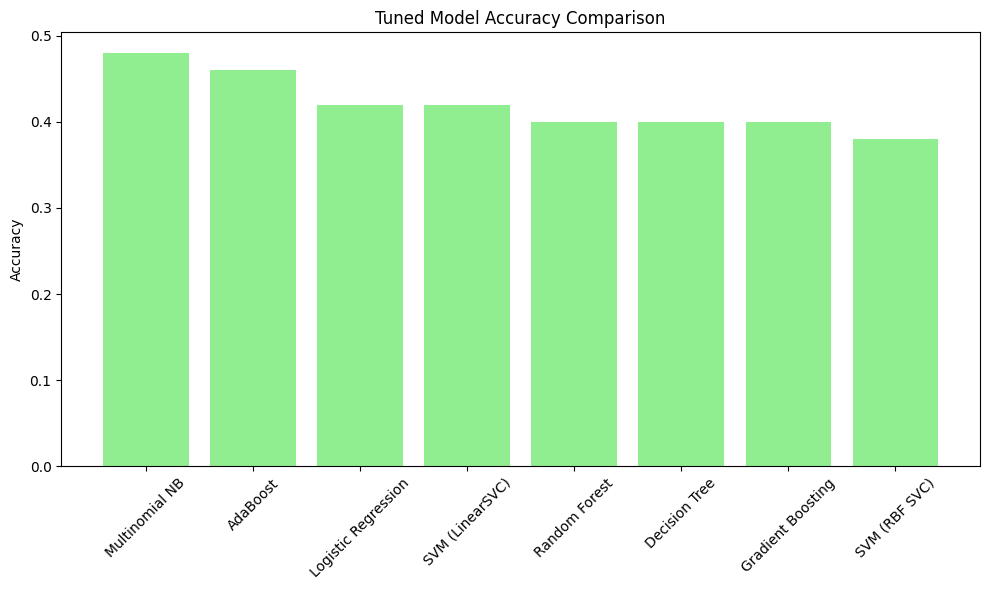

In [20]:
# ==========================================================
# 🔎 10️⃣ Tuned Model Comparison
# ==========================================================
plt.figure(figsize=(10,6))
sorted_tuned = dict(sorted({k: v["accuracy"] for k, v in tuned_results.items()}.items(), key=lambda x: x[1], reverse=True))
plt.bar(sorted_tuned.keys(), sorted_tuned.values(), color='lightgreen')
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.title("Tuned Model Accuracy Comparison")
plt.tight_layout()
plt.show()